# Mounting Google Drive

In [0]:
##### before running it, make sure you don't have lots of big files in your google drive
##### otherwise it's going to take too long to finish running it before giving the TIMEOUT error
##### also save the train_controls, train_patients, val_controls, val_patients to your drive and
##### create a "train" folder with train_controls, train_patients in it, and 
##### a "val" folder with val_controls, val_patients in it.
##### change the train_dir and val_dir in the next cell to the dir of your train and val folder
##### e.g. my train and val folder are saved in the "deep learning" dir

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Loading Train, Val, and Test Data Using Keras ImageDataGenerator

In [0]:
train_dir = "/gdrive/My Drive/new_dataset/train/"
val_dir = "/gdrive/My Drive/new_dataset/val/"
test_dir = "/gdrive/My Drive/new_dataset/test/"

img_width = 600
img_height = 450
batch_size = 5
channels = 3
epochs = 25
#learning_rate = 0.01

nb_train_samples = 410
nb_validation_samples = 150
nb_test_samples = 200

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)             
valid_datagen = ImageDataGenerator(rescale=1./255)    
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)   

validation_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True) #weight toward one class or another

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

#Keras takes care of generating labels if the directory structure matches above!
label_mapT = train_generator.class_indices
print(label_mapT)

label_mapV = validation_generator.class_indices
print(label_mapV)

label_mapTe = test_generator.class_indices
print(label_mapTe)

for data_batch, labels_batch in train_generator:
    print ('data batch shape:', data_batch.shape)
    #print(data_batch)
    print('labels batch shape:', labels_batch.shape)
    #print(labels_batch)
    break

Found 410 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
{'controls': 0, 'patients': 1}
{'controls': 0, 'patients': 1}
{'controls': 0, 'patients': 1}
data batch shape: (5, 600, 450, 3)
labels batch shape: (5,)


# Building the Model Architecture & Training the Model

In [0]:
import numpy as np 
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Softmax, Flatten, Dense, BatchNormalization 
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras import regularizers
import tensorflow as tf
from keras.models import Sequential

from keras.callbacks import TensorBoard

#from keras.layers import Input, Dense
from keras.models import Model

input_shape = (img_width, img_height, channels)
model = Sequential()
model.add(Conv2D(32,(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32,(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())

model.add(Conv2D(64,(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
# model.add(Dense(1024))
# # model.add(Activation('relu'))
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dense(128))
# model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples / batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples / batch_size,
    shuffle=False) # // batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 598, 448, 32)      896       
_________________________________________________________________
activation_10 (Activation)   (None, 598, 448, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 299, 224, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 297, 222, 32)      9248      
_________________________________________________________________
activation_11 (Activation)   (None, 297, 222, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 148, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 146, 109, 64)      18496     
__________

# Testing on Untouched Subset of Atlantis Patients and Controls

In [0]:
#TEST Accuracy on fraction from same group results in quite high accuracy but could get higher...
#print(train_generator.filenames)
#print(validation_generator.filenames)

nb_test_samples = 200

test_generator.reset()

result = model.evaluate_generator(test_generator, steps=nb_test_samples / batch_size)
print(result)

predictions = model.predict_generator(test_generator, steps=nb_test_samples / batch_size, 
                                      workers=1, use_multiprocessing=False)
print(np.round(predictions))
print(len(predictions))

zeroCnt = 0
oneCnt = 0

for i in range(len(predictions[:100])):
  if np.round(predictions[i]) == 0:
    #print(predictions[i])
    zeroCnt += 1
  else:
    oneCnt += 1
    print(i)
    #print(predictions[i])
    
print('TopZeros:')
print(zeroCnt)
print('TopOnes:')
print(oneCnt)

zeroCnt = 0
oneCnt = 0

for i in range(len(predictions[100:])):
  if np.round(predictions[i + 100]) == 0:
    #print(predictions[i])
    zeroCnt += 1
    print(i)
  else:
    oneCnt += 1
    #print(predictions[i])

print('BottomZeros:')
print(zeroCnt)
print('BottomOnes:')
print(oneCnt)

    
img_path = "/gdrive/My Drive/new_dataset/test/patients/24215.png"
from keras.preprocessing import image                             
import numpy as np

img = image.load_img(img_path, target_size=(img_width, img_height))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.                                               


print(img_tensor.shape)
#validation_generator.classes

[2.6412526014155584, 0.8100000105798244]
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]

In [0]:
control_list, patient_list = test_generator.filenames[:100], test_generator.filenames[100:]

print(test_generator.filenames[:100])
print(test_generator.filenames[100:])

control_idx_list = [4,5,8,14,27,32,49,50,54,56,57,60,64,65,67,69,74,75,83,90,92,95,96,97,98,99]
patient_idx_list = [5,9,12,13,27,31,38,39,43,46,47,57,73,78,83,87,95,96,97,98]

from google.colab import files

patient_name_list = [patient_list[i] for i in patient_idx_list]
control_name_list = [control_list[i] for i in control_idx_list]

for i in range(len(patient_name_list)):
    files.download(test_dir+patient_name_list[i])

for i in range(len(control_name_list)):
    files.download(test_dir+control_name_list[i])

['controls/View2098.png', 'controls/View2099.png', 'controls/View2100.png', 'controls/View2101.png', 'controls/View2102.png', 'controls/View2103.png', 'controls/View2104.png', 'controls/View2105.png', 'controls/View2106.png', 'controls/View2107.png', 'controls/View2108.png', 'controls/View2109.png', 'controls/View2110.png', 'controls/View2111.png', 'controls/View2112.png', 'controls/View2113.png', 'controls/View2114.png', 'controls/View2115.png', 'controls/View2116.png', 'controls/View2117.png', 'controls/View2118.png', 'controls/View2119.png', 'controls/View2120.png', 'controls/View2121.png', 'controls/View2122.png', 'controls/View2123.png', 'controls/View2124.png', 'controls/View2125.png', 'controls/View2126.png', 'controls/View2127.png', 'controls/View2128.png', 'controls/View2129.png', 'controls/View2130.png', 'controls/View2131.png', 'controls/View2132.png', 'controls/View2133.png', 'controls/View2134.png', 'controls/View2135.png', 'controls/View2136.png', 'controls/View2137.png',

# Testing on Early Glaucoma Dataset

In [0]:
#TEST Accuracy on Early Glaucoma Dataset (actually about 50% of these are classified as controls by experts 
#but were patients according to the training group criteria), so 50% accuracy make sense!!
test_dir = "/gdrive/My Drive/test/" 

img_width = 600
img_height = 450

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

nb_test_samples = 102

test_generator.reset()

result = model.evaluate_generator(test_generator, steps=nb_test_samples / batch_size)
print(result)

predictions = model.predict_generator(test_generator, steps=nb_test_samples / batch_size)
print(np.round(predictions))
print(len(predictions))

zeroCnt = 0
oneCnt = 0

for i in range(len(predictions)):
  if np.round(predictions[i]) == 0:
    #print(predictions[i])
    zeroCnt += 1
  else:
    oneCnt += 1
    #print(i)
    #print(predictions[i])
    
print(zeroCnt)
print(oneCnt)

Found 102 images belonging to 2 classes.
[5.6919331842777945, 0.6176470640827628]
[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]
102
18
84


In [0]:
print(test_generator.filenames)

['test_controls/control1.png', 'test_controls/control10.png', 'test_controls/control11.png', 'test_controls/control12.png', 'test_controls/control13.png', 'test_controls/control14.png', 'test_controls/control15.png', 'test_controls/control16.png', 'test_controls/control17.png', 'test_controls/control18.png', 'test_controls/control19.png', 'test_controls/control2.png', 'test_controls/control20.png', 'test_controls/control21.png', 'test_controls/control22.png', 'test_controls/control23.png', 'test_controls/control24.png', 'test_controls/control25.png', 'test_controls/control26.png', 'test_controls/control27.png', 'test_controls/control28.png', 'test_controls/control29.png', 'test_controls/control3.png', 'test_controls/control30.png', 'test_controls/control31.png', 'test_controls/control32.png', 'test_controls/control33.png', 'test_controls/control34.png', 'test_controls/control35.png', 'test_controls/control36.png', 'test_controls/control37.png', 'test_controls/control38.png', 'test_cont

# Visualizing Layer Activations

(1, 598, 448, 32)


<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7f9199cba208>>

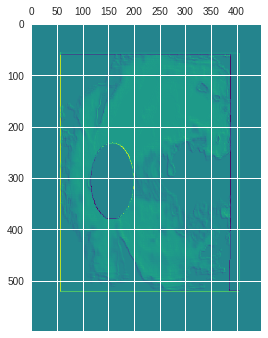

In [0]:
import matplotlib.pyplot as plt

#plt.imshow(img_tensor[0])
#plt.show()

from keras import models

layer_outputs = [layer.output for layer in model.layers[:100]]               
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

import matplotlib.pyplot as plt
plt.figure()
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

model.summary

In [0]:
only change: learning_rate = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_10 (Conv2D)           (None, 598, 448, 32)      896       
_________________________________________________________________
activation_16 (Activation)   (None, 598, 448, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 299, 224, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 297, 222, 32)      9248      
_________________________________________________________________
activation_17 (Activation)   (None, 297, 222, 32)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 148, 111, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 146, 109, 64)      18496     
_________________________________________________________________
activation_18 (Activation)   (None, 146, 109, 64)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 73, 54, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 252288)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16146496  
_________________________________________________________________
activation_19 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_20 (Activation)   (None, 1)                 0         
=================================================================
Total params: 16,175,201
Trainable params: 16,175,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
82/81 [==============================] - 11s 137ms/step - loss: 0.8043 - acc: 0.7439 - val_loss: 0.4269 - val_acc: 0.8400
Epoch 2/25
82/81 [==============================] - 10s 125ms/step - loss: 0.4496 - acc: 0.8610 - val_loss: 0.3285 - val_acc: 0.8600
Epoch 3/25
82/81 [==============================] - 11s 132ms/step - loss: 0.4309 - acc: 0.8927 - val_loss: 0.4190 - val_acc: 0.8733
Epoch 4/25
82/81 [==============================] - 11s 132ms/step - loss: 0.2782 - acc: 0.9024 - val_loss: 0.3382 - val_acc: 0.8667
Epoch 5/25
82/81 [==============================] - 11s 132ms/step - loss: 0.2230 - acc: 0.9366 - val_loss: 0.3726 - val_acc: 0.8667
Epoch 6/25
82/81 [==============================] - 11s 132ms/step - loss: 0.1756 - acc: 0.9293 - val_loss: 0.5217 - val_acc: 0.8467
Epoch 7/25
82/81 [==============================] - 11s 135ms/step - loss: 0.1665 - acc: 0.9561 - val_loss: 0.6094 - val_acc: 0.8467
Epoch 8/25
82/81 [==============================] - 11s 134ms/step - loss: 0.1256 - acc: 0.9537 - val_loss: 0.4967 - val_acc: 0.8467
Epoch 9/25
82/81 [==============================] - 11s 139ms/step - loss: 0.0835 - acc: 0.9756 - val_loss: 1.0375 - val_acc: 0.8667
Epoch 10/25
82/81 [==============================] - 11s 136ms/step - loss: 0.1446 - acc: 0.9683 - val_loss: 0.5893 - val_acc: 0.8800
Epoch 11/25
82/81 [==============================] - 11s 135ms/step - loss: 0.0564 - acc: 0.9780 - val_loss: 1.3348 - val_acc: 0.8533
Epoch 12/25
82/81 [==============================] - 11s 135ms/step - loss: 0.0699 - acc: 0.9854 - val_loss: 1.7125 - val_acc: 0.8267
Epoch 13/25
82/81 [==============================] - 11s 136ms/step - loss: 0.0630 - acc: 0.9780 - val_loss: 0.8991 - val_acc: 0.8667
Epoch 14/25
82/81 [==============================] - 11s 135ms/step - loss: 0.0518 - acc: 0.9829 - val_loss: 1.5595 - val_acc: 0.8400
Epoch 15/25
82/81 [==============================] - 11s 129ms/step - loss: 0.0634 - acc: 0.9854 - val_loss: 1.3560 - val_acc: 0.8667
Epoch 16/25
82/81 [==============================] - 11s 129ms/step - loss: 0.0963 - acc: 0.9878 - val_loss: 1.9791 - val_acc: 0.8267
Epoch 17/25
82/81 [==============================] - 10s 127ms/step - loss: 0.0079 - acc: 0.9976 - val_loss: 1.3477 - val_acc: 0.8667
Epoch 18/25
82/81 [==============================] - 11s 128ms/step - loss: 0.1764 - acc: 0.9805 - val_loss: 1.6813 - val_acc: 0.8667
Epoch 19/25
82/81 [==============================] - 11s 129ms/step - loss: 0.0164 - acc: 0.9951 - val_loss: 1.4131 - val_acc: 0.8733
Epoch 20/25
82/81 [==============================] - 11s 128ms/step - loss: 0.0675 - acc: 0.9951 - val_loss: 1.2343 - val_acc: 0.8667
Epoch 21/25
82/81 [==============================] - 11s 134ms/step - loss: 0.0332 - acc: 0.9927 - val_loss: 1.3326 - val_acc: 0.8800
Epoch 22/25
82/81 [==============================] - 11s 128ms/step - loss: 0.0195 - acc: 0.9976 - val_loss: 1.4183 - val_acc: 0.8733
Epoch 23/25
82/81 [==============================] - 11s 130ms/step - loss: 0.1052 - acc: 0.9927 - val_loss: 1.7462 - val_acc: 0.8733
Epoch 24/25
82/81 [==============================] - 11s 128ms/step - loss: 0.0146 - acc: 0.9976 - val_loss: 1.4800 - val_acc: 0.8867
Epoch 25/25
82/81 [==============================] - 10s 128ms/step - loss: 0.0934 - acc: 0.9878 - val_loss: 1.5759 - val_acc: 0.8867

<keras.callbacks.History at 0x7f91992f7cc0>